<a href="https://colab.research.google.com/github/Shanty-01/quantitative-structure-activity-relationship-modeling/blob/main/chEMBL_Alzheimer_Glycogen_synthase_kinase_3_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* This project aims to create a model that will predict the potential of a molecule as a drug candidate for Alzheimer's disease.
* The model will predict the IC50 of a molecule towards the target glycogen synthase kinase-3.
## About
* Research has shown that increased activity of glycogen synthase kinase-3(GSK-3β) beta is strongly linked to the development of Alzheimer's disease. This is due to its contribution in the hyperphosphorylation of tau protein, the main component of neurofibrillary tangles (NFTs), one of the hallmarks of Alzheimer's disease. Thus GSK-3β inhibition could reduce neurodegeneration caused by tau phosphorylation[1].  

* IC50 (Half-maximal Inhibitory Concentration) is a measure of the concentration of a drug or compound required to inhibit a particular biological or biochemical process by 50%. If a molecule has a low IC50 in respect to GSK-3β, the molecule has the potential to be a GSK-3β inhibitor.

* chEMBL is a publicly available relational database containing bioactive molecules with drug-like properties along with their 2-D structures, calculated properties (e.g. logP, Molecular Weight, Lipinski Parameters, etc.) and abstracted bioactivities (e.g. binding constants, pharmacology and ADMET data).

 * The dataset includes the 2D structure (SMILES) and IC50 values for molecules targeting GSK-3β, which can be used as the training data to build a model for predicting the IC50 of molecules to inhibit GSK-3β. The model that predicts IC50 values is an example of a Quantitative Structure-Activity Relationship (QSAR) model.

### References
[1] C. L. Sayas and J. Ávila, “GSK-3 and Tau: A Key Duet in Alzheimer’s Disease,” Cells, vol. 10, no. 4, p. 721, Mar. 2021, doi: https://doi.org/10.3390/cells10040721.


# Imports

In [ ]:
%%capture
! pip install chembl_webresource_client
! pip install rdkit
! pip install padelpy
! pip install lazypredict
! pip install torcheval

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from chembl_webresource_client.new_client import new_client
from rdkit.Chem import Descriptors, Lipinski
from rdkit import Chem
from padelpy import padeldescriptor
from padelpy import from_smiles
from lazypredict.Supervised import LazyRegressor
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Get bioactivity data of the target molecule, GSK-3β

In [ ]:
target_name = 'Glycogen synthase kinase-3 beta'

In [ ]:
# Search target
target = new_client.target
target_query = target.search(target_name).filter(organism='Homo sapiens')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Glycogen synthase kinase-3,36.00,False,CHEMBL2095188,"[{'accession': 'P49840', 'component_descriptio...",PROTEIN FAMILY,9606
1,"[{'xref_id': 'P49841', 'xref_name': None, 'xre...",Homo sapiens,Glycogen synthase kinase-3 beta,34.00,False,CHEMBL262,"[{'accession': 'P49841', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,Axin-1/Glycogen synthase kinase-3 beta,29.00,False,CHEMBL3883309,"[{'accession': 'P49841', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
3,"[{'xref_id': 'P49840', 'xref_name': None, 'xre...",Homo sapiens,Glycogen synthase kinase-3 alpha,27.00,False,CHEMBL2850,"[{'accession': 'P49840', 'component_descriptio...",SINGLE PROTEIN,9606
4,"[{'xref_id': 'P13807', 'xref_name': None, 'xre...",Homo sapiens,Muscle glycogen synthase,24.00,False,CHEMBL4000,"[{'accession': 'P13807', 'component_descriptio...",SINGLE PROTEIN,9606
...,...,...,...,...,...,...,...,...,...
2263,[],Homo sapiens,UDP-glucuronosyltransferases (UGTs),1.00,False,CHEMBL4523985,"[{'accession': 'P22310', 'component_descriptio...",PROTEIN FAMILY,9606
2264,[],Homo sapiens,Secretory phospholipase A2,1.00,False,CHEMBL4524005,"[{'accession': 'Q5R387', 'component_descriptio...",PROTEIN FAMILY,9606
2265,[],Homo sapiens,P2X receptor,1.00,False,CHEMBL4524012,"[{'accession': 'P51575', 'component_descriptio...",PROTEIN FAMILY,9606
2266,[],Homo sapiens,Vasoactive intestinal peptide receptor,1.00,False,CHEMBL4524128,"[{'accession': 'P41587', 'component_descriptio...",PROTEIN FAMILY,9606


In [ ]:
selected_target = targets[targets.pref_name == target_name].target_chembl_id.iloc[0]

In [ ]:
# Get bioactivity data
activity = new_client.activity
activities = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
activities =  pd.DataFrame.from_dict(activities)

In [ ]:
# Check contents
print(activities.shape)
print(activities.columns)

(4154, 46)
Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


In [ ]:
to_keep = ['molecule_chembl_id','canonical_smiles','standard_value']
activity = activities[to_keep]

# Data preprocessing

In [ ]:
# Drop rows with NaN value in standard_value or canonical_smiles columns
activity = activity.dropna(subset=['standard_value', 'canonical_smiles'])

In [ ]:
# Drop rows with duplicates of the canonical_smiles column
activity = activity.drop_duplicates(['canonical_smiles'])

In [ ]:
# Get the longest molecular component in smiles
def longest_smiles(smile_string):
  cpd = str(smile_string).split('.')
  return max(cpd, key=len)

activity['canonical_smiles'] = activity.canonical_smiles.map(longest_smiles)

In [ ]:
# Convert the column to float
activity['standard_value'] = activity['standard_value'].astype(float)

In [ ]:
# Statistic description of IC50 values
activity.standard_value.describe()

,standard_value
count,3446.00
mean,44590.30
std,1207456.00
min,0.01
25%,60.00
50%,707.00
75%,10000.00
max,50000000.00


The mean appears to be significantly larger than the median. It has a large standard deviation, and extremely large outlier. These indicate that the distribution is right-tailed. Let's visualize it.

<Axes: >

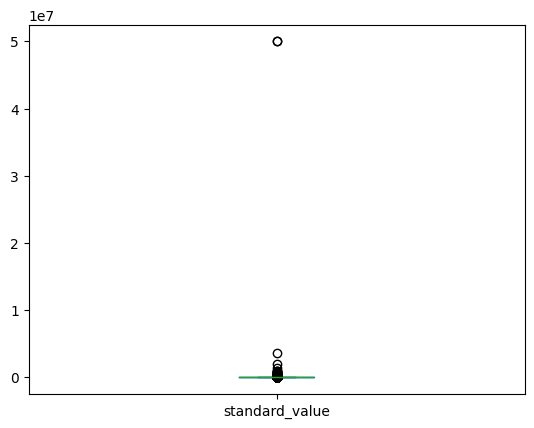

In [ ]:
# Box plot of IC50 values
activity.standard_value.plot.box()

The outlier has compressed the display of other data points. Let's remove the outlier.

In [ ]:
# Remove outlier
activity = activity[activity.standard_value < 5 * 10**7]

<Axes: >

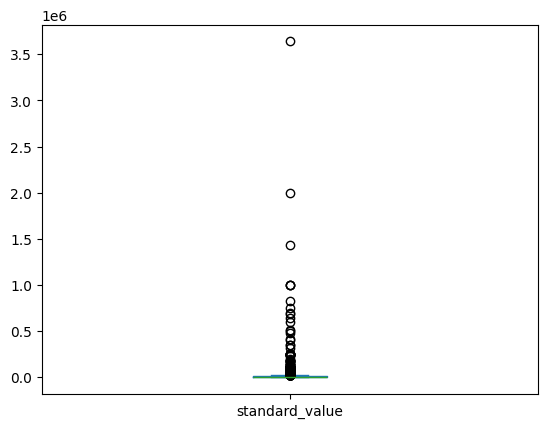

In [ ]:
# Box plot of IC50 values
activity.standard_value.plot.box()

Text(0.5, 1.0, 'Log-Scaled IC50 Histogram')

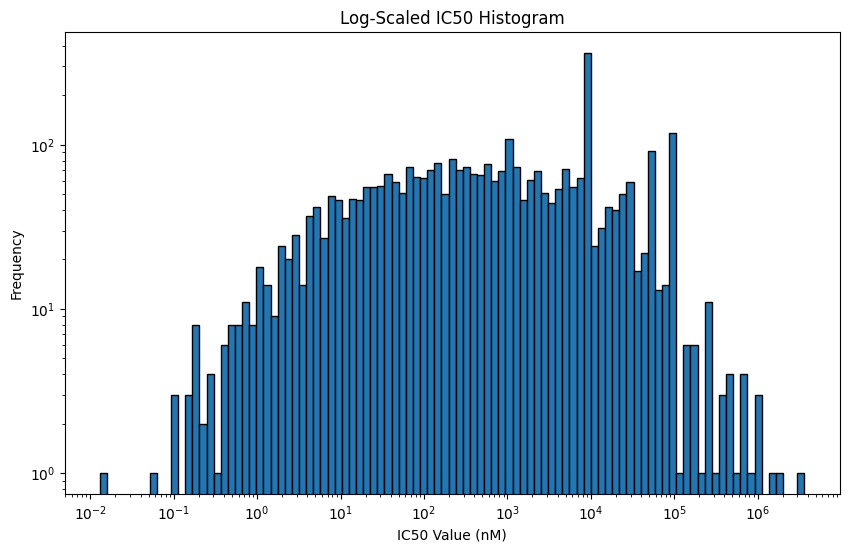

In [ ]:
# Histogram of the IC50
plt.figure(figsize=(10,6))
log_bins = np.logspace(np.log10(activity.standard_value.min()), np.log10(activity.standard_value.max()), 100)
counts, bins, patches = plt.hist(activity.standard_value, bins=log_bins ,log=True, edgecolor='black')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('IC50 Value (nM)')
plt.ylabel('Frequency')
plt.title('Log-Scaled IC50 Histogram')

## Data labelling : active, inactive or intermediate
IC50 is a unit measure of the concentration of a drug or compound required  
 to inhibit a particular biological or biochemical process by 50%.

* Active (strongly potent): IC50 < 1000 nM  
* Intermediate (moderate activity) : 1000 nM < IC50 < 10000 nM  
* Inactive : IC50 > 10000 nM  


In [ ]:
# Data labelling : active, inactive or intermediate
def activity_label(ic50):
  if ic50 < 1000:
    return 'active'
  elif ic50 > 10000:
    return 'inactive'
  else:
    return 'intermediate'

In [ ]:
activity['class'] = activity.standard_value.map(activity_label)

In [ ]:
# Data pre-processing
activity.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'class'], dtype='object')

## Comparison between active and inactive molecules with Lipinski descriptors

Lipinski's Rule of Five is a set of guidelines to evaluate the drug-likeness of a molecule based on its physicochemical properties, such as:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10


In [ ]:
def lipinski_descriptors(smiles_string):
  mol = Chem.MolFromSmiles(smiles_string)
  MolWt = Descriptors.MolWt(mol)
  MolLogP = Descriptors.MolLogP(mol)
  NumHDonors = Lipinski.NumHDonors(mol)
  NumHAcceptors = Lipinski.NumHAcceptors(mol)
  return MolWt, MolLogP, NumHDonors, NumHAcceptors

activity['MolWt'], activity['MolLogP'], activity['NumHDonors'], \
activity['NumHAcceptors'] = zip(*activity.canonical_smiles.map(lipinski_descriptors))

In [ ]:
# Convert IC50 to pIC50 to allow a more uniform distribution
def pic50(ic50):
  # Values greater than 10**8 will be fixed at 10**8,
  # otherwise the negative logarithmic value will become negative.
  if ic50 > (10**8):
    ic50 = 10**8
  # Convert IC50 which is in nM to M
  m = ic50 * (10**-9)
  # Convert IC50 to negative log scale
  return -np.log10(m)

activity['pIC50'] = activity.standard_value.map(pic50)

In [ ]:
activity.pIC50.describe()

,pIC50
count,3444.00
mean,6.22
std,1.36
min,2.44
25%,5.00
50%,6.15
75%,7.22
max,10.89


In [ ]:
# Filter out the intermediate class
no_inter = activity[activity['class'] != 'intermediate']

Text(0, 0.5, 'Frequency')

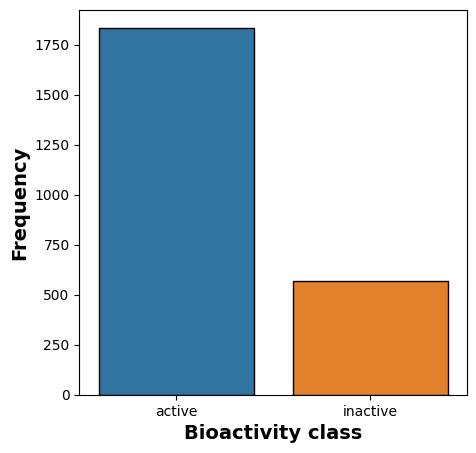

In [ ]:
# Frequency plot of active and inactive class
plt.figure(figsize=(5,5))
sns.countplot(x='class', data=no_inter, edgecolor='black', hue='class')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

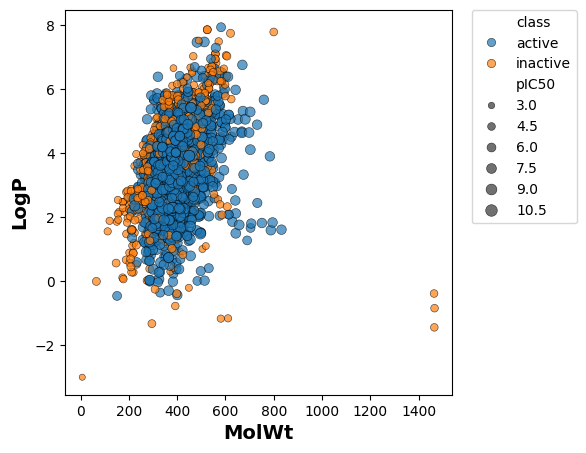

In [ ]:
# Scatter plot of MW and LogP
plt.figure(figsize=(5,5))
sns.scatterplot(x='MolWt', y='MolLogP', data=no_inter, hue='class', size='pIC50',
                edgecolor='black', alpha=0.7)
plt.xlabel('MolWt', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

### Does the Lipinski descriptors differ significantly between the active and inactive groups?

In [ ]:
def mannwhitney(descriptor, alpha=0.05):
  np.random.seed(42)
  # Get the chosen descriptor for the active and inactive class
  active = activity[activity['class'] == 'active'][descriptor]
  inactive = activity[activity['class'] == 'inactive'][descriptor]

  # Compute P-value
  stat, p = mannwhitneyu(active,inactive)

  # Interpret
  if p > alpha :
    print(f'P-value : {p}\nSame distribution (fail to reject H0)')
  else :
    print(f'P-value : {p}\nDifferent distribution (reject H0)')

##### pIC50

Text(0, 0.5, 'pIC50 value')

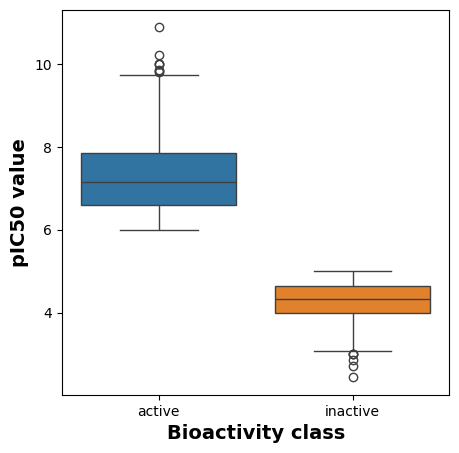

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='pIC50', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('pIC50')

P-value : 2.0539334364424757e-284
Different distribution (reject H0)


##### MolWt

Text(0, 0.5, 'MolWt')

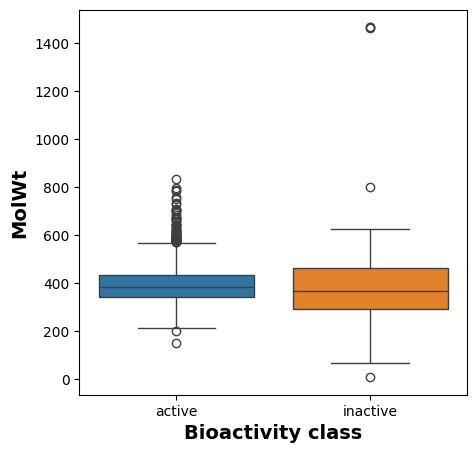

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='MolWt', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MolWt', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('MolWt')

P-value : 0.0003175000244501326
Different distribution (reject H0)


##### LogP

Text(0, 0.5, 'MolLogP')

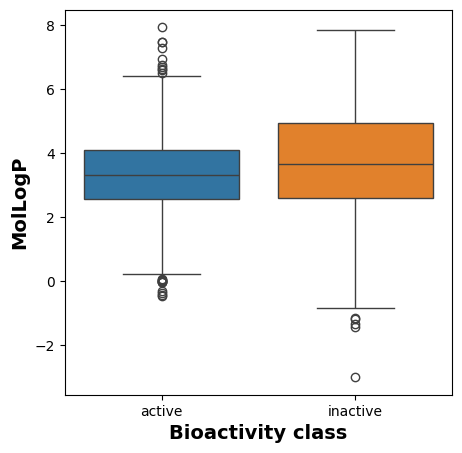

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='MolLogP', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MolLogP', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('MolLogP')

P-value : 6.784438601161338e-08
Different distribution (reject H0)


##### NumHDonors


Text(0, 0.5, 'NumHDonors')

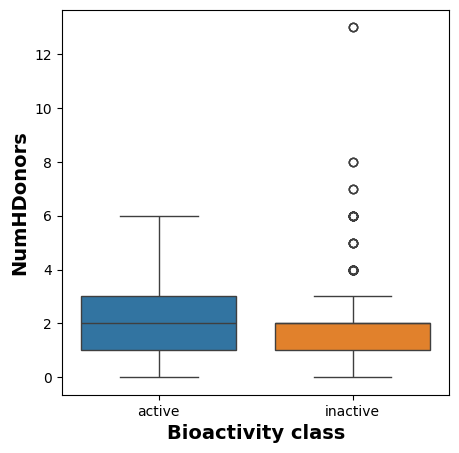

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='NumHDonors', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('NumHDonors')

P-value : 7.196483415479644e-05
Different distribution (reject H0)


The classication of molecules by thresholding:
* Active (strongly potent): IC50 < 1000 nM
* Inactive : IC50 > 10000 nM  

are reflected in the 4 Lipinski's descriptor which have statistically significant difference between the actives and inactives.

# Calculate Fingerprint Descriptors
SMILES Fingerprint encodes an organic molecule's SMILES strings into a binary bit string where each bit represents the presence or absence of 34 different chemical substructure. We could create the SMILES Fingerprint of the active and inactive molecules and use it as our training data.

In [ ]:
# Create SMILES file
smi = activity[['canonical_smiles', 'molecule_chembl_id']]
smi.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
padeldescriptor(mol_dir='molecule.smi',
                d_file='fingerprint_output.csv',
                standardizenitro=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
X = pd.read_csv('fingerprint_output.csv')

In [ ]:
X.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL322970,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL112564,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL321421,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL388978,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL114582,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_name = X.pop('Name')

In [ ]:
y = activity['pIC50']

In [ ]:
X.shape, y.shape

((3444, 881), (3444,))

In [ ]:
# Remove low variance features
selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
X = selection.fit_transform(X)

In [ ]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Create and Train Model
We'll use the Lazy Predict library to quickly compare regression models.

In [ ]:
# Define the regression models with LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,
                    random_state=42)

In [ ]:
models,predictions = reg.fit(X_train, X_val, y_train, y_val)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [00:39<00:00,  1.06it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 2066, number of used features: 154
[LightGBM] [Info] Start training from score 6.227955


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.47,0.59,0.85,4.26
XGBRegressor,0.45,0.57,0.87,0.27
LGBMRegressor,0.45,0.57,0.87,0.26
HistGradientBoostingRegressor,0.44,0.56,0.88,1.00
BaggingRegressor,0.43,0.56,0.88,0.38
MLPRegressor,0.41,0.54,0.90,4.02
SVR,0.39,0.53,0.92,0.79
NuSVR,0.38,0.52,0.93,0.65
KNeighborsRegressor,0.35,0.49,0.95,0.07


RandomForestRegressor	model achieved the lowest RMSE of 0.85, but it took significantly longer to train than XGBRegressor model with the second lowest RMSE of 0.87.  
Therefore, we'll proceed with the XGBRegressor model and use Grid Search to tune its hyperparameters.

# Hyperparameter Tuning


In [ ]:
early_stopping = EarlyStopping(rounds=10, save_best=True, maximize=False)
model = XGBRegressor(
    objective='reg:squarederror',
    early_stopping_rounds=10,
    random_state=42,
    callbacks=[early_stopping]
)
param_grid = {
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators': [300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [9, 10, 12],
    'colsample_bytree': [0.1, 0.2, 0.3],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error'
)
grid_search.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=[<xgboost.callback.EarlyStopping object at 0x7f23ec0835e0>],
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.1, 0.2, 0.3],
                         'learning_rate': [0.07, 0.08, 0.09],
                         'max_depth': [3, 4, 5],
                         'min_child_weight': [9, 10, 12],
                         'n_estimators': [300]},
             scoring='neg_root_mean_squared_error')

In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 0.2, 'learning_rate': 0.09, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 300}


In [ ]:
# Predict and evaluate RMSE
y_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("Validatiion RMSE:", rmse)

y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", rmse)

Validatiion RMSE: 0.8564844674514411
Test RMSE: 0.8765901185277599


We will test the model on 5 molecules and classify the prediction based on the chosen threshold

In [ ]:
# Convert pIC50 back to IC50
def pic50_to_IC50(pic50):
    return 10**(-pic50) * 10**9

X_ = X[:5]
name = X_name[:5]
y_ = best_model.predict(X_)
y_ic50 = pic50_to_IC50(y_)
df = pd.DataFrame({'Name': name, 'Predicted IC50':y_ic50})

df['Classification'] = df['Predicted IC50'].apply(
    lambda x: 'Active' if x < 1000 else 'Inactive' if x > 100000 else 'Intermediate')
df

,Name,Predicted IC50,Classification
0,CHEMBL322970,114.69,Active
1,CHEMBL112564,767.20,Active
2,CHEMBL321421,908.20,Active
3,CHEMBL388978,584.11,Active
4,CHEMBL114582,16968.48,Intermediate


# Conclusion
In this project, we have:  

* Extracted molecules that could inhibit GSK-3β from the chEMBL dataset.
* Classify molecules to active and inactive groups by the threshold of :
 - Active (strongly potent): IC50 < 1000 nM   
 -Inactive : IC50 > 10000 nM .

* Conducted the Mann–Whitney test for the Lipinski descriptor between active and inactive groups. With p-value < 0.05, the labelled active and inactive molecules differ significantly in their Lipinski descriptor values, therefore validating the threshold used value.
* Trained an XGBRegressor model to map SMILE Fingerprint of a molecule to its IC50 value to inhibit GSK-3β. The model evaluation shows:  
 - Validatiion RMSE: 0.856
 - Test RMSE: 0.876


